![Tulane](https://github.com/tulane-cmps6730/main/blob/main/img/banner.png?raw=true)

<center>

<font size="+3">Representing Words</font>

[Aron Culotta](https://cs.tulane.edu/~aculotta/)  
[Tulane University](https://cs.tulane.edu/)

<a href="http://colab.research.google.com/github/tulane-cmps6730/main/blob/main/notebooks/04_Language_Modles.ipynb">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Google_Colaboratory_SVG_Logo.svg/320px-Google_Colaboratory_SVG_Logo.svg.png"  width=10%/></a>
<a href="https://github.com/tulane-cmps6730/main/tree/main">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/GitHub_Invertocat_Logo.svg/240px-GitHub_Invertocat_Logo.svg.png" width=6%/></a>

In this module, we'll learn about better ways of representing words based on the contexts in which they appear.

</center>

<hr size=10 color=#285C4D>

## Word representations



Up to now, we've represented words by simply mapping them to a unique column index.

E.g., the document "happy" becomes

$$[0,0,1,0,\ldots,0]$$

where "happy" is assigned index 2.

<br><br>
However, this representation ignores any similarity between related words.

E.g., "glad" may be

$$[0,0,0,0,0,0,1,\ldots,0]$$

where "glad" is assigned index 6

There is no way for us to tell that "happy" and "glad" are similar terms using this word representation.

<br><br>

<u> Why does this matter? </u>

- **Reason 1: Statistical efficiency**

Recall our logistic regression model, which has a separate coefficient $\theta_j$ for each term $w_j$

We would expect the coefficient $\theta_{\mathrm{glad}}$ to be similar to the coefficient $\theta_{\mathrm{happy}}$.

Or, perhaps we could collapse these coefficients into a single $\theta_{\mathrm{positive\_emotion}}$

Recall that the quality of our estimates for each $\theta_j$ depends in part on the number of training examples containing term $w_j$. By collapsing terms, or enforcing that similar terms have similar coefficients, we can make more efficient use of the limited training data we have.

<br><br>

- **Reason 2: Out-of-vocabulary words**

Given our limited training data, there are many words which may appear in the testing data but not the training data.

E.g., "elated" has no corresponding $\theta$ coefficient if it does not appear in the training data.

Even more important for informal text (SMS, social media) where abbreviations, emoticons, and neologisms abound.

<hr size=10 color=#285C4D>

## Language modeling as a classification task



Recall the ngram language model:

$$p(w_i \mid w_{i-1} \ldots w_{i-n})$$


One way to represent words is to summarize the contexts in which they appear.

<u>Assumption</u>: words that appear in similar contexts have similar semantics or syntactic functions.

E.g., what are the most probable words $p(w_i \mid \mathrm{"I\: feel\: so"})$?
 - happy
 - glad
 - **sad**

<br><br>
How do we formalize this?


<u> Idea:</u> represent each word as a vector of values
- Words with similar vectors should be similar

### Predicting the next word



$$p(w_i \mid w_{i-1} \ldots w_{i-n})$$

Predict word $w_i$ given as "features" the prior $n$ words.


Any classifier can be used (Naive Bayes, logistic regression, neural nets, ...)
- class labels: all possible words in the vocabulary (multi-class classification)
- features: the words that appear around word $w_i$

In [12]:
# common imports
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from numpy import array as npa
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})


d = Counter()
d.update(['a', 'b', 'c'])
d.update(['a', 'a', 'b'])
d
docs = ['I am Sam',
        'You are Sam',
        'Sam I am',
        'I do not like green eggs and ham',
        'Sam I was',
        'I am Dan',
       ]

In [13]:
def iter_ngrams(doc, n):
    """Return a generator over ngrams of a document.
    Params:
      doc...list of tokens
      n.....size of ngrams"""
    return (doc[i : i+n] for i in range(len(doc)-n+1))

def iterate_examples(docs, n):
    for doc in docs:
        for ngram in iter_ngrams(doc.split(), n):
            yield ngram[:-1], ngram[-1]


[x for x in iterate_examples(docs, 3)]

[(['I', 'am'], 'Sam'),
 (['You', 'are'], 'Sam'),
 (['Sam', 'I'], 'am'),
 (['I', 'do'], 'not'),
 (['do', 'not'], 'like'),
 (['not', 'like'], 'green'),
 (['like', 'green'], 'eggs'),
 (['green', 'eggs'], 'and'),
 (['eggs', 'and'], 'ham'),
 (['Sam', 'I'], 'was'),
 (['I', 'am'], 'Dan')]

In [14]:
# DictVectorizer: useful for creating sparse matrices from a list of dicts.

from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
X = vec.fit_transform([
                        {'a': 10, 'b': 1},
                        {'b': 100, 'c': 1000},
                      ])
print('feature names:\n', vec.get_feature_names_out())
print('feature matrix:\n', X.todense())

feature names:
 ['a' 'b' 'c']
feature matrix:
 [[  10.    1.    0.]
 [   0.  100. 1000.]]


In [15]:
# Convert preceeding terms into a single feature per instance.
# E.g., ["I", "am"] -> "I_am"
vec = DictVectorizer()
X = vec.fit_transform({'_'.join(x[0]): 1} for x in iterate_examples(docs, 3))
y = np.array([x[1] for x in iterate_examples(docs, 3)])
display(pd.DataFrame(np.column_stack((X.todense(), y)),
                     columns=np.concatenate((vec.get_feature_names_out(), ['label']))))

,I_am,I_do,Sam_I,You_are,do_not,eggs_and,green_eggs,like_green,not_like,label
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sam
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sam
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,am
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,not
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,like
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,green
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,eggs
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,and
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,ham
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,was


In [16]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X, y)
df = pd.DataFrame(clf.coef_,
                  columns=vec.get_feature_names_out(),
                  index=clf.classes_)
df

,I_am,I_do,Sam_I,You_are,do_not,eggs_and,green_eggs,like_green,not_like
Dan,0.684724,-0.077961,-0.145917,-0.072604,-0.077961,-0.077961,-0.077961,-0.077961,-0.077961
Sam,0.475743,-0.148798,-0.265301,0.683027,-0.148798,-0.148798,-0.148798,-0.148798,-0.148798
am,-0.137439,-0.077379,0.672159,-0.072060,-0.077379,-0.077379,-0.077379,-0.077379,-0.077379
and,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,-0.083420,0.798619,-0.083420,-0.083420
eggs,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,-0.083420,-0.083420,0.798619,-0.083420
green,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,-0.083420,-0.083420,-0.083420,0.798619
ham,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,0.798619,-0.083420,-0.083420,-0.083420
like,-0.147598,-0.083420,-0.155517,-0.077717,0.798619,-0.083420,-0.083420,-0.083420,-0.083420
not,-0.147598,0.798619,-0.155517,-0.077717,-0.083420,-0.083420,-0.083420,-0.083420,-0.083420
was,-0.137439,-0.077379,0.672159,-0.072060,-0.077379,-0.077379,-0.077379,-0.077379,-0.077379


In [17]:
# Can now use the classifier to predict the next word,
# given the previous words.
i_am = vec.transform({'I_am': 1})
print(clf.predict(i_am))
display(pd.DataFrame(zip(clf.classes_, clf.predict_proba(i_am)[0])))

['Sam']


,0,1
0,Dan,0.157450
1,Sam,0.262293
2,am,0.068644
3,and,0.073828
4,eggs,0.073828
5,green,0.073828
6,ham,0.073828
7,like,0.073828
8,not,0.073828
9,was,0.068644


<hr size=10 color=#285C4D>

## Using model parameters to represent words



- Each word $w_i$ has a separate $\theta_i$ vector in the classifier.
- High values $\theta_{ij} \in \theta_i$ means that bigram $j$ is predictive of word $i$
- Perhaps words with similar vectors are also similar?
  - Appear in similar contexts

In [18]:
# Which preceding bigrams are predictive of Dan?
df.loc['Dan'].sort_values(ascending=False)

,Dan
I_am,0.684724
You_are,-0.072604
do_not,-0.077961
eggs_and,-0.077961
like_green,-0.077961
not_like,-0.077961
I_do,-0.077961
green_eggs,-0.077961
Sam_I,-0.145917


In [19]:
# Which preceding bigrams are predictive of Sam?
df.loc['Sam'].sort_values(ascending=False)

,Sam
You_are,0.683027
I_am,0.475743
do_not,-0.148798
like_green,-0.148798
not_like,-0.148798
I_do,-0.148798
eggs_and,-0.148798
green_eggs,-0.148798
Sam_I,-0.265301


In [20]:
# Which preceding bigrams are predictive of like?
df.loc['like'].sort_values(ascending=False)

,like
do_not,0.798619
You_are,-0.077717
green_eggs,-0.083420
like_green,-0.083420
not_like,-0.083420
I_do,-0.083420
eggs_and,-0.083420
I_am,-0.147598
Sam_I,-0.155517


### Interlude: Interpreting coefficients

<br><br>



In **linear regression** it is fairly straightforward to interpret what $\theta_i$ means:

$$y = \sum_i x_i \cdot \theta_i$$

> for every unit increase in $x_i$, $y$ increases by $\theta_i$

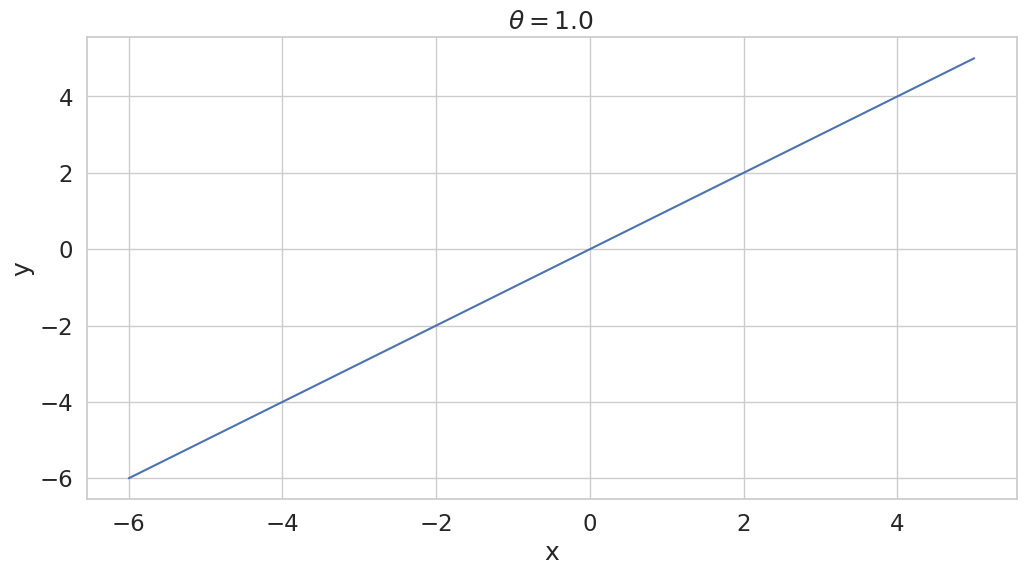

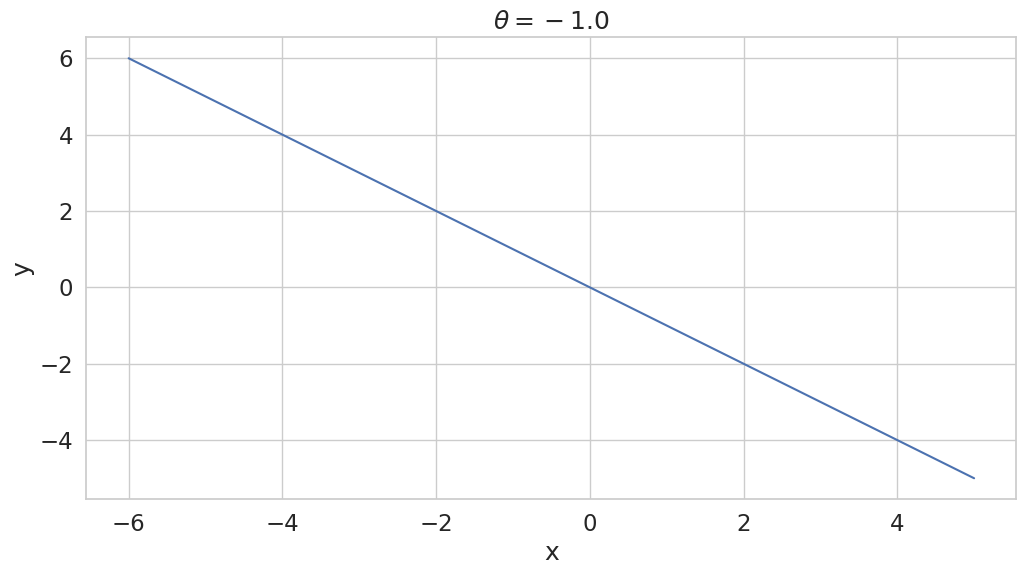

In [21]:
x = np.arange(-6, 6)
theta=.2

def plot_linear(x, theta):
    plt.figure()
    plt.plot(x, x*theta)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'$\theta=%.1f$' % theta)
    plt.show()

plot_linear(x, 1)
plot_linear(x, -1)


But the relationship between $\theta$ and $y$ is nonlinear for logistic regression:


$$y = \frac{1}{1 + e^{-\sum_i x_i \cdot \theta_i}}$$

> for every unit increase in $x_i$, $y$ increases by ?


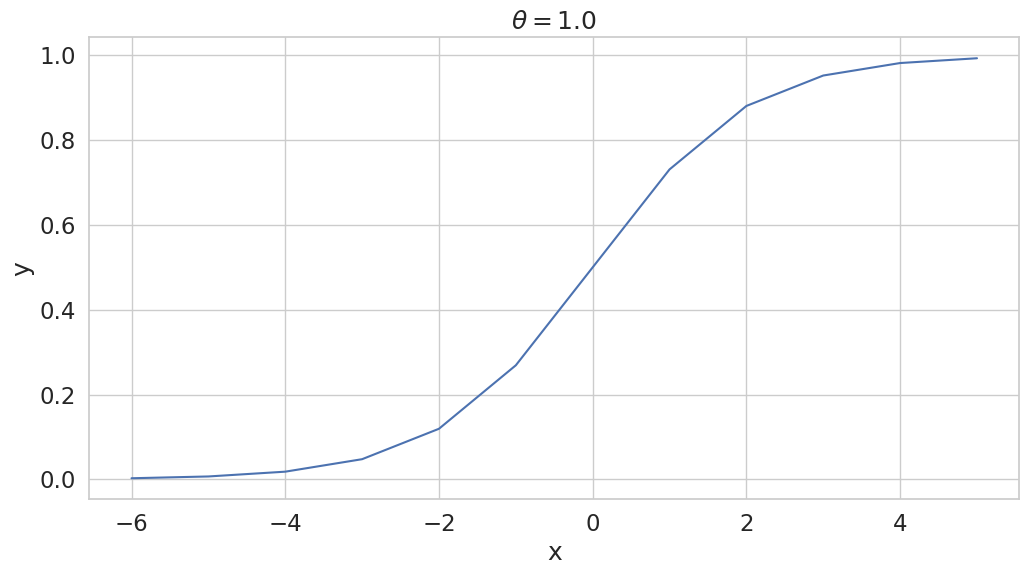

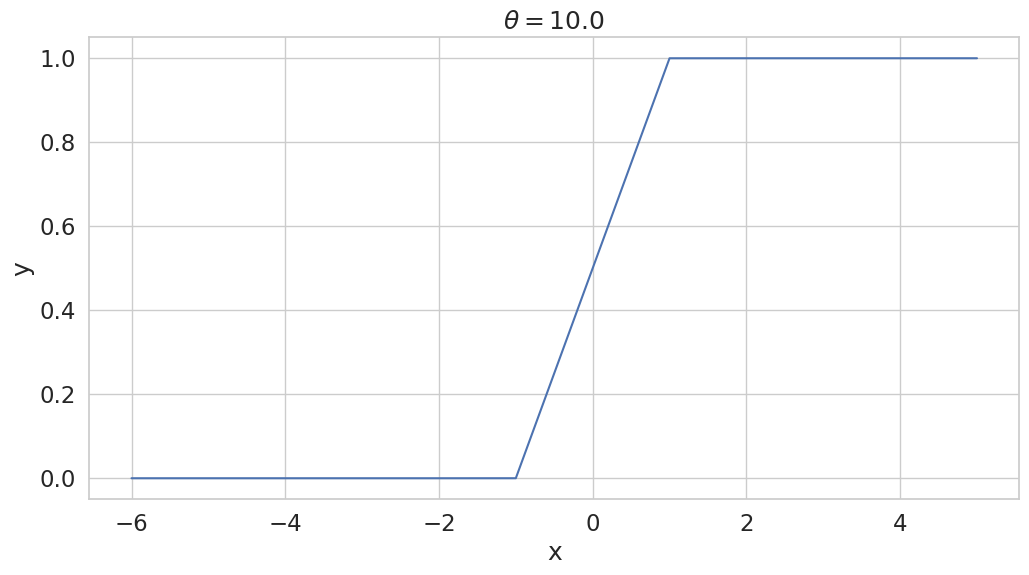

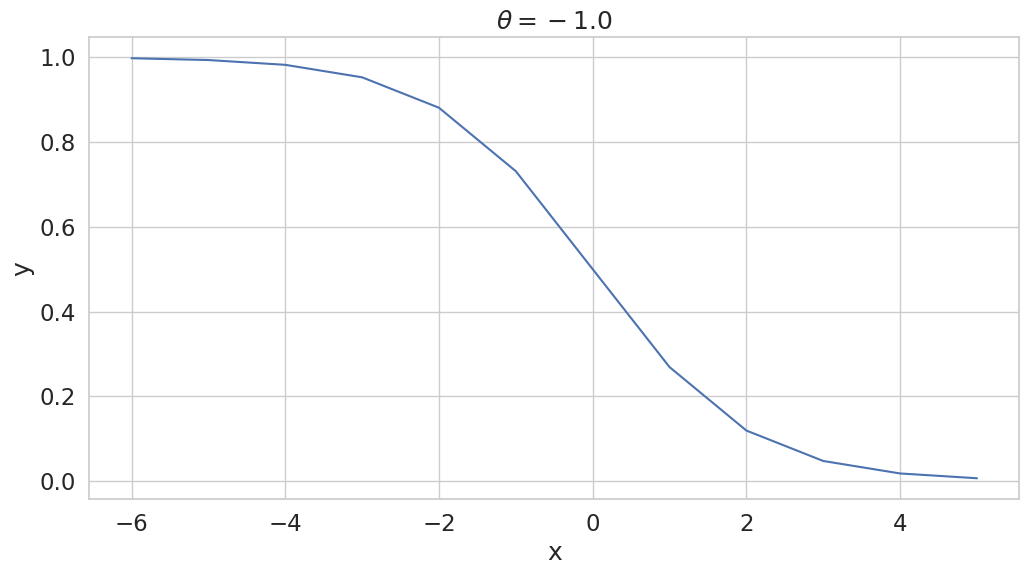

In [22]:
import math

def logistic(xi, theta):
    return 1 / (1 + math.exp(-xi*theta))

def plot_logistic(x, theta):
    plt.figure()
    plt.plot(x, [logistic(xi, theta) for xi in x])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(r'$\theta=%.1f$' % theta)
    plt.show()

x = np.arange(-6, 6)
plot_logistic(x, 1)
plot_logistic(x, 10)
plot_logistic(x, -1)

<br>

The shape of these graphs imply that the relationship between $\theta$ and $y$ depends on $x$.

E.g., $\theta$ changes the probability of $y$ more when $x$ is near $0$ than when it is near $4$.

<br>

One way to interpret logistic regression coefficients is in terms of **odds**.

If probability of positive class is $p \equiv p(y|\vec{x})$, then the **odds** of the positive class is $\frac{p}{1-p}$

E.g., an odds of $2$ means the positive class is twice as likely as the negative class.




In [23]:
def odds(p):
    return p / (1-p)

pd.DataFrame([(pi, odds(pi)) for pi in np.arange(10)/10], columns=['p', 'odds'])

,p,odds
0,0.0,0.000000
1,0.1,0.111111
2,0.2,0.250000
3,0.3,0.428571
4,0.4,0.666667
5,0.5,1.000000
6,0.6,1.500000
7,0.7,2.333333
8,0.8,4.000000
9,0.9,9.000000


With some arithmetic, we can rewrite the logistic function as:

$$\log \Big(\frac{p}{1-p} \Big) = \sum_i x_i \theta_i $$

This means we can interpret $\theta_i$ as the log of the odds of the positive class.

Equivalently, $e^{\theta_i}$ is the odds of the positive class.

So, if $\theta_i=0.5$, then $e^{0.5} \approx 1.65$  means that the odds for a document containing word $i$ being positive is about 65% higher than a document without word $i$, all else being equal.



<br><br>

... back to our classifier:

<hr size=10 color=#285C4D>

## Computing word similarity

In [24]:
# here are our word coefficients again...
df

,I_am,I_do,Sam_I,You_are,do_not,eggs_and,green_eggs,like_green,not_like
Dan,0.684724,-0.077961,-0.145917,-0.072604,-0.077961,-0.077961,-0.077961,-0.077961,-0.077961
Sam,0.475743,-0.148798,-0.265301,0.683027,-0.148798,-0.148798,-0.148798,-0.148798,-0.148798
am,-0.137439,-0.077379,0.672159,-0.072060,-0.077379,-0.077379,-0.077379,-0.077379,-0.077379
and,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,-0.083420,0.798619,-0.083420,-0.083420
eggs,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,-0.083420,-0.083420,0.798619,-0.083420
green,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,-0.083420,-0.083420,-0.083420,0.798619
ham,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,0.798619,-0.083420,-0.083420,-0.083420
like,-0.147598,-0.083420,-0.155517,-0.077717,0.798619,-0.083420,-0.083420,-0.083420,-0.083420
not,-0.147598,0.798619,-0.155517,-0.077717,-0.083420,-0.083420,-0.083420,-0.083420,-0.083420
was,-0.137439,-0.077379,0.672159,-0.072060,-0.077379,-0.077379,-0.077379,-0.077379,-0.077379


<br><br>

How can we compute the similarity between such vectors?

### Cosine similarity

A common way of measuring similarity between vectors:

$$ cos(x, y) = \frac{\sum_{i} x_i * y_i}{\sqrt{\sum_i x_i^2} \sqrt{\sum_i y_i^2}}$$

$cos(x,y) = 1 \rightarrow$ $x$ and $y$ are identical  
$cos(x,y) = -1 \rightarrow$ $x$ and $y$ are opposite

![cos](https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/cos.png?raw=1)

In [25]:
# Are words with similar coefficients related?
from math import sqrt

def similarity(word1, word2, clf):
    # find the coefficient vector for each word
    i1 = list(clf.classes_).index(word1)
    i2 = list(clf.classes_).index(word2)
    coef1 = clf.coef_[i1]
    coef2 = clf.coef_[i2]
    # compute cosine similarity
    return np.dot(coef1, coef2) / (sqrt(np.dot(coef1, coef1)) * sqrt(np.dot(coef2, coef2)))

similarity('Sam', 'Dan', clf)

0.5569160186357877

In [26]:
similarity('Sam', 'like', clf)

-0.17226811992546784

We can do the same using a neural network, though now we will also have a hidden layer.

In [27]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
                    activation='logistic',
                    solver='lbfgs',
                    max_iter=1000,
                    random_state=1234)

mlp.fit(X, y)
mlp.coefs_

[array([[-0.68578046, -0.04235121, -0.17227504,  0.74735998,  0.08191569,
         -0.27192813, -0.23607616, -0.69873823,  1.255627  , -0.48023946,
         -0.49064185, -1.11988141, -0.28252166, -0.16243237,  1.06838764,
         -0.39819185, -0.34073146, -0.0419387 , -0.16994788,  0.2702917 ,
         -1.19813338,  0.45864499, -0.64155731, -0.87950786,  0.49186909,
          0.09870508,  0.15495672,  1.11758011, -0.30894765, -0.96331833,
          1.54766618,  0.72844186, -0.06373848, -0.66283879,  0.73140635,
          0.52165027,  0.07350595,  1.24446167, -0.13568886,  0.9818111 ,
         -0.06498918, -0.03611873,  0.46241378,  0.45553908,  0.90396241,
         -0.27981372,  0.71342783,  0.61583121,  0.66219449,  1.09416472,
         -0.75465675,  1.1442943 ,  0.35935926, -1.3999709 , -0.16999116,
          0.68382489,  0.54800423,  1.22424686,  0.49408697,  0.00359254,
         -0.50491009,  0.61207319, -0.02014291, -0.98129832, -0.35061354,
         -0.58264673, -0.9656948 ,  0.

<hr size=10 color=#285C4D>

## Word vectors



If we run the above approach on a very large, unlabeled dataset, we can associate a parameter vector $\theta_i$ with each word $i$.

We can use this vector to represent each word.

In [28]:
df

,I_am,I_do,Sam_I,You_are,do_not,eggs_and,green_eggs,like_green,not_like
Dan,0.684724,-0.077961,-0.145917,-0.072604,-0.077961,-0.077961,-0.077961,-0.077961,-0.077961
Sam,0.475743,-0.148798,-0.265301,0.683027,-0.148798,-0.148798,-0.148798,-0.148798,-0.148798
am,-0.137439,-0.077379,0.672159,-0.072060,-0.077379,-0.077379,-0.077379,-0.077379,-0.077379
and,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,-0.083420,0.798619,-0.083420,-0.083420
eggs,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,-0.083420,-0.083420,0.798619,-0.083420
green,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,-0.083420,-0.083420,-0.083420,0.798619
ham,-0.147598,-0.083420,-0.155517,-0.077717,-0.083420,0.798619,-0.083420,-0.083420,-0.083420
like,-0.147598,-0.083420,-0.155517,-0.077717,0.798619,-0.083420,-0.083420,-0.083420,-0.083420
not,-0.147598,0.798619,-0.155517,-0.077717,-0.083420,-0.083420,-0.083420,-0.083420,-0.083420
was,-0.137439,-0.077379,0.672159,-0.072060,-0.077379,-0.077379,-0.077379,-0.077379,-0.077379


<u>Problems with this approach?</u>

<br><br><br>

- **Scalability**: for an ngram model, we must have a different parameter for every distinct ngram in the data
- **Sparsity**: for a given word, only a small number of ngram features will be present. E.g.:
  - "I am so happy"
  - "You are super glad"
  - In this example, there would be no feature overlap, reducing the similarity between "happy" and "glad"
  
  
<u> Solution </u>
- Use a small, dense vector to represent each word.
- When computing features, use this word vector to represent preceding words, rather than the words themselves.


$p(w_i \mid w_{i-1} \ldots w_{i-n})$ becomes  
$p(w_i \mid v_{i-1} \ldots v_{i-n})$  
where $v_i$ is the vector representation of word $i$.

<u> Objective </u>

Jointly learn parameters and <u>word representation</u> to enable prediction of $p(w_i \mid v_{i-1} \ldots v_{i-n})$.

In [29]:
# E.g., fix dimension of each word vector to 3
# Initialze to small random values in [-.1, .1]
vec_dim = 3
np.random.seed(1234)
word_vectors = np.random.uniform(-.1, .1, (len(clf.classes_), 3))
word_vectors = pd.DataFrame(word_vectors, index=clf.classes_)
word_vectors
# Want to update these parameters so that similar words have similar values.

,0,1,2
Dan,-0.061696,0.024422,-0.012454
Sam,0.057072,0.055995,-0.045481
am,-0.044707,0.060374,0.091628
and,0.075187,-0.028437,0.000199
eggs,0.036693,0.042540,-0.025950
green,0.012239,0.000617,-0.097246
ham,0.054565,0.076528,-0.027023
like,0.023079,-0.084924,-0.026235
not,0.086628,0.030276,-0.020559
was,0.057746,-0.036633,0.013620


<hr size=10 color=#285C4D>


## Using Neural Nets for Word Representation

To represent features in classifier:
$p(w_i \mid v_{i-1} \ldots v_{i-n})$  

we will concatenate the vectors for each prior word.

E.g.  features for
$p(w_i \mid \mathrm{green\: eggs})$ :


In [30]:
np.concatenate((word_vectors.loc['green'],
                word_vectors.loc['eggs']))

array([ 0.01223924,  0.00061663, -0.09724631,  0.03669259,  0.04254041,
       -0.02594985])

But, how will we optimize these vectors?

Just doing logistic regression will associate weights with each vector element, but not change the word representations.



<u> Neural nets to the rescue! </u>

![nn](https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/nn.png?raw=1)

- Word vectors become hidden nodes in a neural network.
- An additional hidden layer allows non-linear transformations of word vectors
- Training the model to optimize $p(w_i \mid v_{i-1} \ldots v_{i-n})$ results in "useful" vectors for $v$.
- **Word representations are useful if they help us predict the next word in a sentence.**

### Neural Net Implementations

`sklearn`'s `MLPClassifier` class supports only a limited set of structures for neural nets.

```python
MLPClassifier(hidden_layer_sizes=[50, 10])
```

In fact, we can't build the network above -- it would look like this instead:

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/nnbroken.png?raw=1" width=70%/>

What's the difference and why does it matter?

<br>

Instead we will use PyTorch <https://pytorch.org/>
- Very mature, open-source library for training neural nets
- Developed at Facebook research



<hr size=10 color=#285C4D>

## Simple word prediction neural net

Let's start with a somewhat simpler model:

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/smallnn.png?raw=1" width=50%/>


Given an input word, predict what other word appears nearby.






### Debugging neural nets with synthetic data



Once we start designing our own networks, it is very easy to make a mistake.

It is helpful to start with a small, easy dataset where we know what the network should do.

If we don't get near perfect accuracy on such data, then something is wrong with our implementation.

Here, we'll learn word embeddings for an artificially easy task:

Two words appear near each other iff they start with the same letter:

> "All aardvarks ate apples."

> "Both bobcats broke bottles."

We will generate a dataset of **word pairs** $(w_1, w_2)$ indicating that $w_1$ occurrs near $w_2$.

In [31]:
animals = ['aardvark', 'albatross', 'alligator', 'alpaca', 'anole', 'ant', 'anteater', 'antelope', 'ape', 'armadillo',
           'baboon', 'badger', 'barracuda', 'bat', 'bear', 'bee', 'bison', 'boar', 'bobcat', 'butterfly']
vocab = {w: i for i,w in enumerate(animals)}
a_names = [a for a in animals if a[0] == 'a']
b_names = [b for b in animals if b[0] == 'b']


def make_animal_data():
    np.random.seed(42)
    animal_data = pd.DataFrame(zip(np.random.choice(a_names, size=300),
                                   np.random.choice(a_names, size=300)),
                              columns=['w1', 'w2'])
    animal_data = pd.concat((animal_data,
                           pd.DataFrame(zip(np.random.choice(b_names, size=300),
                                            np.random.choice(b_names, size=300)),
                              columns=['w1', 'w2'])))
    animal_data = animal_data.sample(frac=1, random_state=42)
    # remove where w1==w2
    animal_data = animal_data[animal_data.w1 != animal_data.w2]#.drop_duplicates()
    return animal_data

data = make_animal_data()
data

,w1,w2
110,aardvark,ant
119,bat,bear
265,bee,butterfly
77,ape,albatross
181,anole,armadillo
...,...,...
121,armadillo,aardvark
20,anole,ant
71,anole,ant
270,alpaca,albatross


### PyTorch Implementation



PyTorch has a number of classes to help create and train neural nets. Some important concepts:

**[Tensor](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)**: Multidimensional arrays, very similar to `numpy` arrays. Optimized for GPU usage.

```python
data = [[1, 2],[3, 4]]
torch.tensor(data)
```

```
tensor([[1, 2],
        [3, 4]])
```

**[automatic differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)**: PyTorch will perform back propagation automatically to compute the gradients for each parameter. It can do this by restricting somewhat the network structures and activation functions. See [`torch.nn`](https://pytorch.org/docs/stable/nn.html).


<br><br>

Creating a network consists of a few steps:

1. Create a Python class that subclasses `torch.nn.Module`.
2. In the constructor, define the structure of the network (layers, activation functions)
3. Implement a method called `forward` that computes the forward pass of the neural net. This applies each transformation defined in the constructor in the approriate order and produces an output.
4. Write a method to generate batches of training data.
5. Pick an optimizer to perform gradient descent.

Let's walk through how the above model is implemented in PyTorch.

<br><br>

In [21]:
import torch
import torch.nn as nn
import math


class WordPairModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, verbose=True):
        super(WordPairModel, self).__init__()
        self.verbose = verbose
        # input -> hidden
        # linear == x*A^T + b =~ dense neural net layer
        self.embedding = nn.Linear(vocab_size, embedding_size, bias=False)
        # hidden -> output
        self.hidden = nn.Linear(embedding_size, vocab_size, bias=False)
        # normalize
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        if self.verbose: print('input\n', input)

        embedding = self.embedding(input)
        if self.verbose: print('embedding\n', embedding)

        hidden = self.hidden(embedding)
        if self.verbose: print('hidden\n', hidden)

        output = self.softmax(hidden)
        if self.verbose: print('softmax\n', output)
        return output

- `nn.Linear`: $x A^T + b$
- **embedding**:
  - Input: one-hot encoded word vector $w_1 \in \mathbb{R}^V$. e.g. $<0,1,0 \ldots 0>$
  -  model parameters $A \in \mathbb{R}^{V x H}$
    - $V$: vocabulary size
    - $H$: embedding size
    
- **hidden**:
  - Input: embedding vector $h \in \mathbb{R}^H$. e.g. $<.22,-.01,.3 \ldots 1.2>$
  - model parameters $A \in \mathbb{R}^{H x V}$


- **softmax**

$$
\hbox{softmax}(x) = \frac{e^x}{\sum_i e^{x_i}}
$$
- exponentiate: make things positive
- normalize so it sums to one for all possible outputs.
- How many $x_i$ are there in our model?

<br><br>

Next, we have to convert all of our word pairs into appropriate **tensor** data structures.

In [22]:
def vectorize_one(word, vocabulary):
    """ one-hot encoding"""
    tensor = torch.zeros(1, len(vocabulary))
    tensor[0][vocabulary[word]] = 1.0
    return tensor

def vectorize_batch(rows, vocabulary):
    """
    encode all examples in given list of rows in DataFrame.
    """
    return (torch.cat([vectorize_one(w, vocabulary) for w in rows.w1]),
            torch.cat([vectorize_one(w, vocabulary) for w in rows.w2]))

vectorize_one('anole', vocab)

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [23]:
# vectorize first three rows.
vectorize_batch(data.iloc[:3], vocab)

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1.]]))

In [24]:
# Compute forward pass for first example.
# Note the weights are randomly initialized.
torch.manual_seed(42)
model = WordPairModel(len(vocab), embedding_size=2)
output = model(vectorize_batch(data.iloc[:1], vocab)[0])

input
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
embedding
 tensor([[ 0.1710, -0.1030]], grad_fn=<MmBackward0>)
hidden
 tensor([[ 0.0522, -0.0142,  0.1017,  0.0567,  0.1058, -0.0915, -0.1525,  0.0046,
          0.0395,  0.1464,  0.0573,  0.0624,  0.0522,  0.1434, -0.0286,  0.0845,
          0.1764, -0.0629, -0.1108, -0.0172]], grad_fn=<MmBackward0>)
softmax
 tensor([[0.0509, 0.0476, 0.0535, 0.0512, 0.0537, 0.0441, 0.0415, 0.0486, 0.0503,
         0.0559, 0.0512, 0.0514, 0.0509, 0.0558, 0.0470, 0.0526, 0.0577, 0.0454,
         0.0433, 0.0475]], grad_fn=<SoftmaxBackward0>)


In [25]:
# look at the embedding weights
model.embedding.weight

Parameter containing:
tensor([[ 0.1710,  0.1856, -0.0524,  0.2054, -0.0490,  0.0451, -0.1089,  0.1313,
          0.1971, -0.1640,  0.1944,  0.0419,  0.1652,  0.0303,  0.1078, -0.0316,
          0.1724,  0.0331, -0.1044,  0.0570],
        [-0.1030, -0.0262, -0.0908,  0.1483, -0.1765, -0.1031, -0.0631, -0.1344,
          0.0211, -0.2209,  0.2019, -0.1899,  0.1726,  0.0372, -0.0726,  0.1382,
          0.0348,  0.1807,  0.0244, -0.0705]], requires_grad=True)

In [28]:
# .forward() does the following:
i = vectorize_batch(data.iloc[:1], vocab)[0]
print('i:', i)
# i=1 x 20  embeddings=2 x 20
e = i.mul(model.embedding.weight).sum(dim=1)
print('\nembedding:', e)
h = e.mul(model.hidden.weight).sum(dim=1)
print('\nhidden:', h)
o =  h.exp() / h.exp().sum()
print('\noutput:', o)

i: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

embedding: tensor([ 0.1710, -0.1030], grad_fn=<SumBackward1>)

hidden: tensor([ 0.0522, -0.0142,  0.1017,  0.0567,  0.1058, -0.0915, -0.1525,  0.0046,
         0.0395,  0.1464,  0.0573,  0.0624,  0.0522,  0.1434, -0.0286,  0.0845,
         0.1764, -0.0629, -0.1108, -0.0172], grad_fn=<SumBackward1>)

output: tensor([0.0509, 0.0476, 0.0535, 0.0512, 0.0537, 0.0441, 0.0415, 0.0486, 0.0503,
        0.0559, 0.0512, 0.0514, 0.0509, 0.0558, 0.0470, 0.0526, 0.0577, 0.0454,
        0.0433, 0.0475], grad_fn=<DivBackward0>)


In [29]:
# map from output distribution to predicted word.
def output2label(output, words):
    # 0 if false is most probable prediction, 1 if true
    top_n, top_i = output.topk(1)
    return words[top_i.item()] # , math.exp(top_n)

output2label(output, animals)

'bison'

### Loss functions

We need a loss function to quantify how good our word prediction model is.

For binary case, **Binary Cross Entropy**:

$$BCE(y, y^*) = -y^*(\log y) + (1-y^*)\log(1-y)$$

- $y$: probablity of positive class
- $y^* \in \{0,1\}$ true class label.

<br><br><br>

For multi-class case, **Categorical Cross Entropy**

$$CCE(y, y^*) = -\log \frac{e^{y_{c^*}}}{\sum_c e^{y_c}}$$

- $y_c$ is probability of class $c$
- $c^*$ is the true class.


In [30]:
# input can be normalized...
print(nn.CrossEntropyLoss()(torch.tensor([[.9, .1, .1]]),
                            torch.tensor([[1., 0., 0.]])))
# or unnormalized, in which case the softmax above will normalize it.
print(nn.CrossEntropyLoss()(torch.tensor([[9., 1., 1.]]),
                            torch.tensor([[1., 0., 0.]])))

tensor(0.6411)
tensor(0.0007)


### Training loop

100%|██████████| 80/80 [00:01<00:00, 55.64it/s]


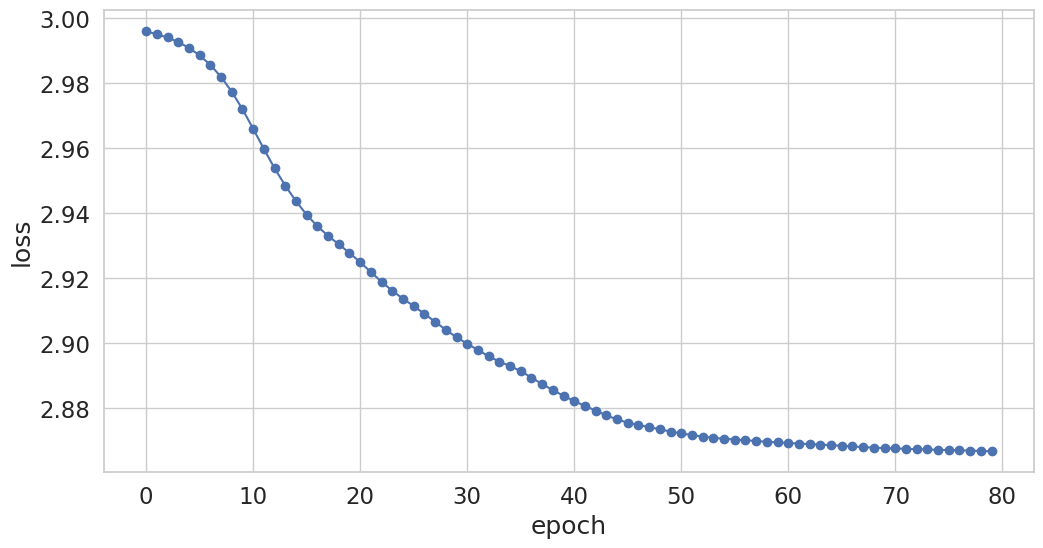

In [35]:
def train_word_pair(data, vocab):
    torch.random.manual_seed(42)  # for reproducibility
    learning_rate = 0.1
    model = WordPairModel(len(vocab), embedding_size=2)
    # binary cross entropy
    # choice of loss function depends on output type of model
    # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
    # criterion = nn.BCELoss()
    criterion = nn.CrossEntropyLoss()
    # fancier version of gradient descent
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)
    model.verbose = False

    loss_val = []
    num_epochs = 80
    # main training loop
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        optimizer.zero_grad() # reset all the gradient information
        inputs, labels = vectorize_batch(data, vocab)
        outputs = model(inputs)
        labels = labels.argmax(axis=1)
        loss = criterion(outputs, labels)
        loss.backward()      # computes all the gradients
        optimizer.step()     # update parameters
        loss_val.append(loss.item())

    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    return model

word_pair_model = train_word_pair(data, vocab)

### Visualizing word embeddings

In [36]:
# get embedding for a word
def word2embedding(word, model, vocabulary):
    return model.embedding(
        vectorize_one(word, vocabulary)).detach().cpu().numpy()[0]
word2embedding('ant', word_pair_model, vocab)

array([ 2.1259937, -2.1343791], dtype=float32)

In [37]:
word2embedding('bee', word_pair_model, vocab)

array([-3.794622, -0.687337], dtype=float32)

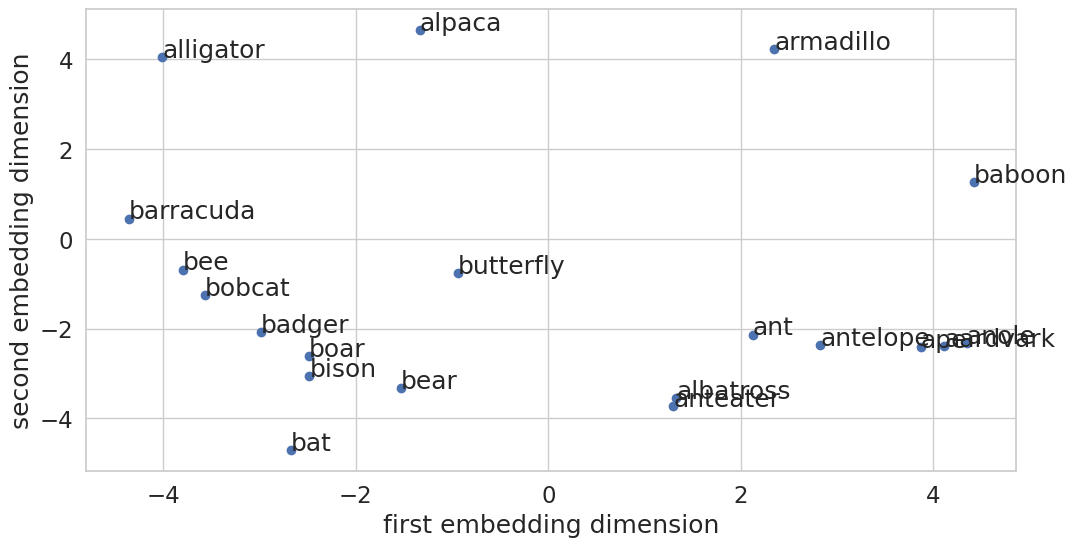

In [38]:
def plot_embeddings(animal_embeddings, animals):
    plt.figure()
    plt.scatter([e[0] for e in animal_embeddings],
                [e[1] for e in animal_embeddings])
    for animal, embed in zip(animals, animal_embeddings):
        plt.annotate(animal, (embed[0], embed[1]))
    plt.xlabel('first embedding dimension')
    plt.ylabel('second embedding dimension')
    plt.show()

animal_embeddings = [word2embedding(animal, word_pair_model, vocab) for animal in animals]
plot_embeddings(animal_embeddings, animals)

<hr size=10 color=#285C4D>

## Binary classification for word representation

In [40]:
# how many parameters in our model?
print(word_pair_model)

WordPairModel(
  (embedding): Linear(in_features=20, out_features=2, bias=False)
  (hidden): Linear(in_features=2, out_features=20, bias=False)
  (softmax): Softmax(dim=1)
)


<br><br><br><br><br>


$V \times H  + H \times V = 2 \times V \times H$  
(input->hidden + hidden->output)

$V$: vocabulary size

$H$: embedding size

One trick for scalability: rather than predict a word, predict whether the two given words appear next to each other:

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/nn2.png?raw=1" width=80%/>

So, input has doubled, but output is now a single binary variable.

<br><br>
But wait, do we really need the additional hidden layer?
<br>
We really just want the two word vectors to be similar for positive examples and dissimilar for negative examples.

<br><br>
Let's take the dot product

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/w2v.png?raw=1" width=60%/>

<br>
This particular network structure is called the <a href="https://arxiv.org/abs/1301.3781">Word2Vec</a> model

<br><br>

But wait, how do we get negative examples?

<br><br><br>

Just sample words that do not appear near each other.

In [41]:
# add negative examples
def add_negatives(data):
    np.random.seed(42)
    data2 = data.copy()
    data2 = pd.concat((data2,
                      pd.DataFrame(zip(np.random.choice(a_names, size=400), np.random.choice(b_names, size=400)), columns=['w1', 'w2'])))
    data2 = pd.concat((data2,
                      pd.DataFrame(zip(np.random.choice(b_names, size=400), np.random.choice(a_names, size=400)), columns=['w1', 'w2'])))

    data2['label'] = [1 if w1[0] == w2[0] else 0 for (w1, w2) in data2.values]
    data2 = data2.sample(frac=1, random_state=42).drop_duplicates()
    return data2
data2 = add_negatives(data)
data2

,w1,w2,label
290,badger,bee,1
341,ape,boar,0
93,bobcat,boar,1
200,baboon,bison,1
187,barracuda,baboon,1
...,...,...,...
160,ant,anteater,1
233,aardvark,alligator,1
240,bobcat,antelope,0
97,anteater,ant,1


In [46]:
def vectorize_batch2(rows, vocabulary):
    """
    return (input_tensor, output_tensor) tuple
    for all examples in rows.
    """
    return (torch.cat([vectorize_one(w, vocabulary) for w in rows.w1]),
            torch.cat([vectorize_one(w, vocabulary) for w in rows.w2]),
            torch.tensor([float(l) for l in rows.label]))

# compare with earlier method.
print('vectorize_batch')
display(vectorize_batch(data2.iloc[:3], vocab))
print('\nvectorize_batch2')
display(vectorize_batch2(data2.iloc[:3], vocab))

vectorize_batch


(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0.]]))


vectorize_batch2


(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0.]]),
 tensor([1., 0., 1.]))

In [47]:
# embed w1 and w2 separately, take their dot product, then predict binary classification.
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size, verbose=True):
        super(Word2Vec, self).__init__()
        self.verbose = verbose
        self.embedding = nn.Linear(vocab_size, embedding_size, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, w1, w2):
        if self.verbose: print('w1\n', w1, '\nw2\n', w2)
        embedding1 = self.embedding(w1)
        embedding2 = self.embedding(w2)
        if self.verbose: print('embedding1\n', embedding1, '\nembedding2\n', embedding2)

        dotprod = torch.mul(embedding1, embedding2).sum(dim=1)
        if self.verbose: print('dotprod\n', dotprod)

        output = self.sigmoid(dotprod)
        if self.verbose: print('sigmoid\n', output)
        return output

torch.random.manual_seed(42)
word2vec = Word2Vec(len(vocab), 2, verbose=True)
print(word2vec)
# test model
bb = vectorize_batch2(data2.iloc[:3], vocab)
output = word2vec(bb[0], bb[1])
print(output)

Word2Vec(
  (embedding): Linear(in_features=20, out_features=2, bias=False)
  (sigmoid): Sigmoid()
)
w1
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0.]]) 
w2
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0.]])
embedding1
 tensor([[ 0.0419, -0.1899],
        [ 0.1971,  0.0211],
        [-0.1044,  0.0244]], grad_fn=<MmBackward0>) 
embedding2
 tensor([[-0.0316,  0.1382],
        [ 0.0331,  0.1807],
        [ 0.0331,  0.1807]], grad_fn=<MmBackward0>)
dotprod
 tensor([-0.0276,  0.0103,  0.0010], grad_fn=

  0%|          | 0/10 [00:00<?, ?it/s]

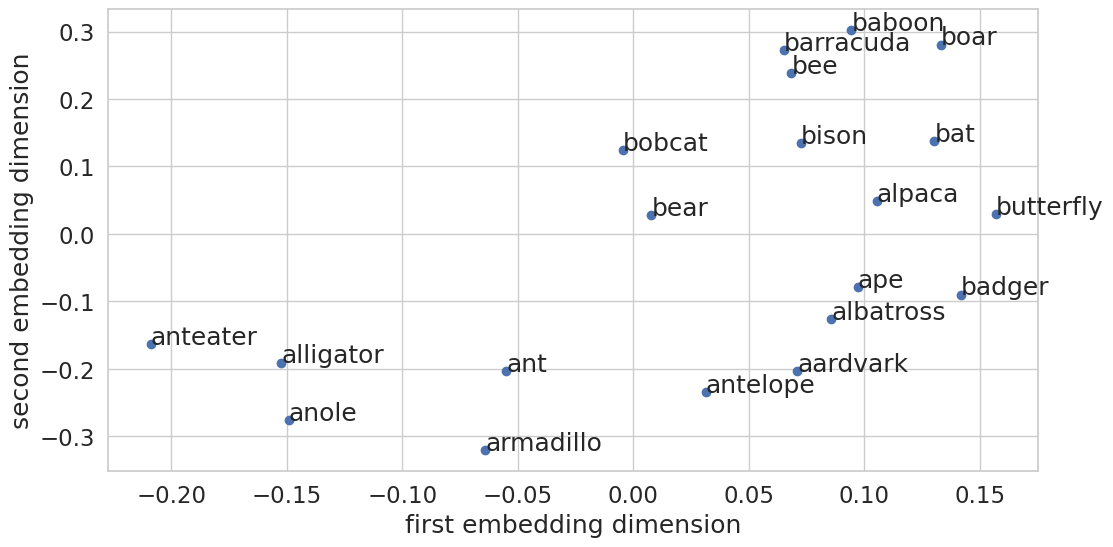

 10%|█         | 1/10 [00:00<00:07,  1.27it/s]

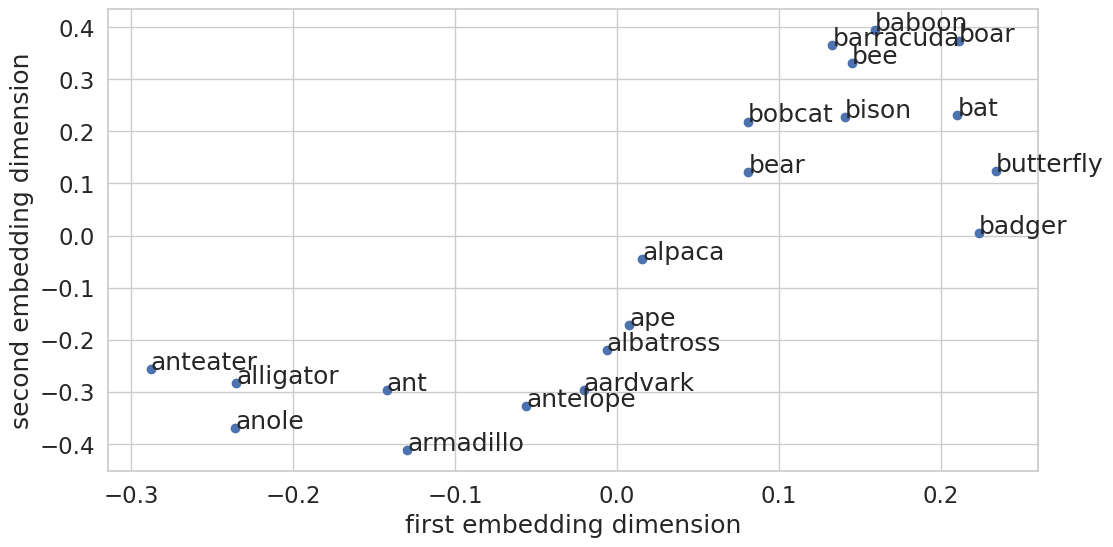

 20%|██        | 2/10 [00:01<00:05,  1.36it/s]

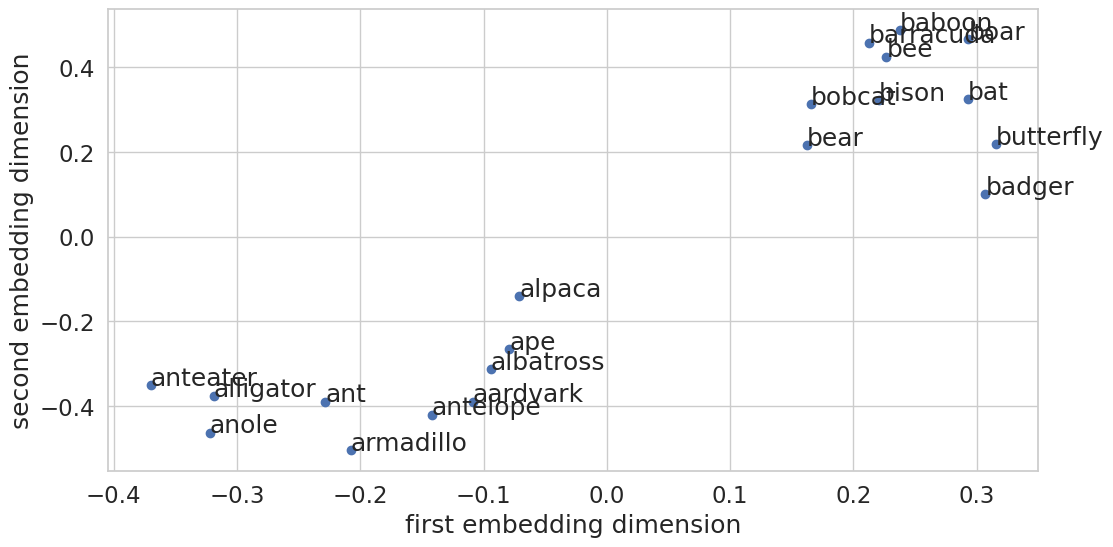

 30%|███       | 3/10 [00:02<00:04,  1.40it/s]

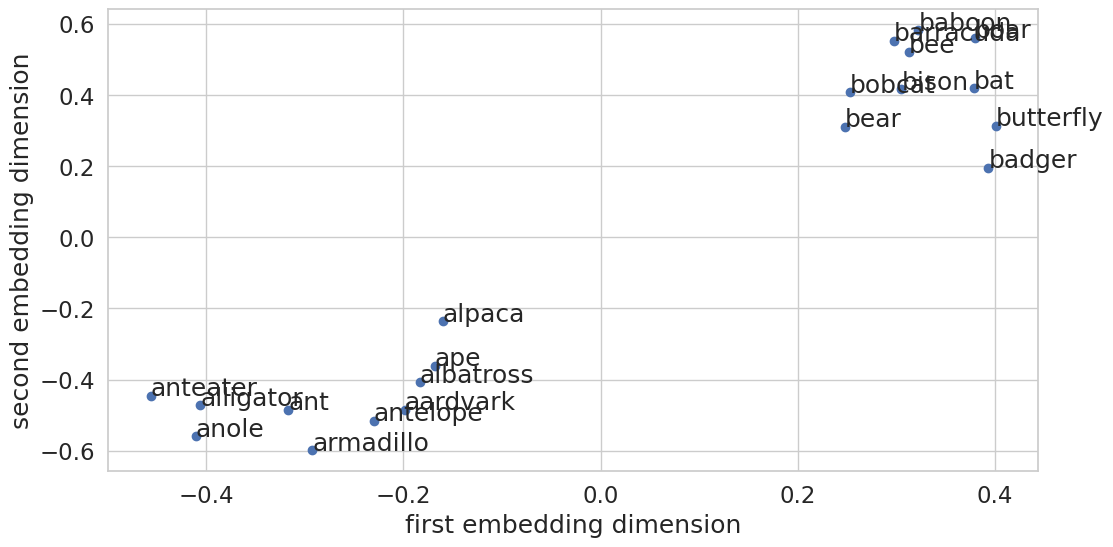

 40%|████      | 4/10 [00:03<00:04,  1.20it/s]

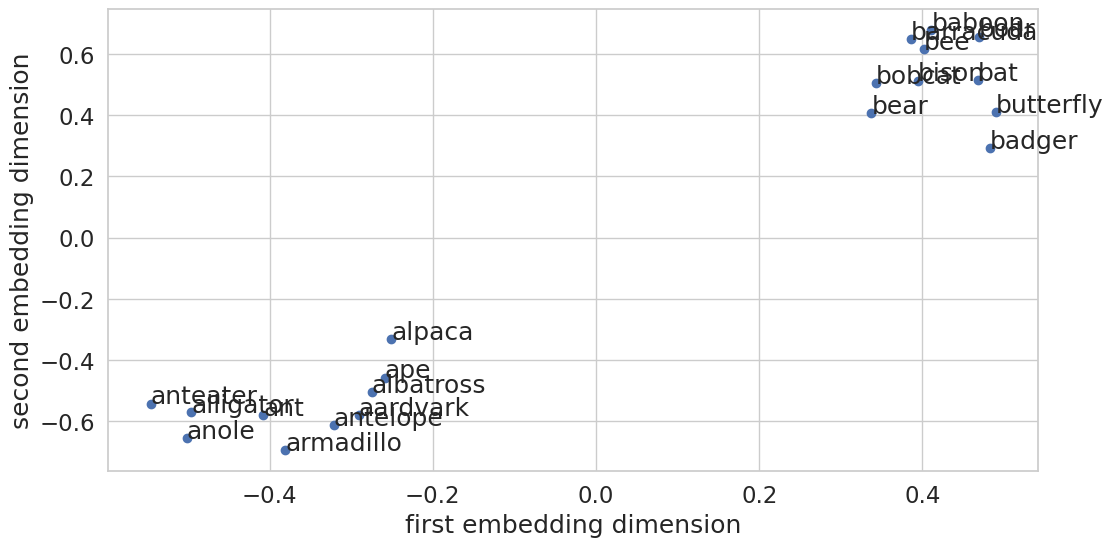

 50%|█████     | 5/10 [00:04<00:04,  1.02it/s]

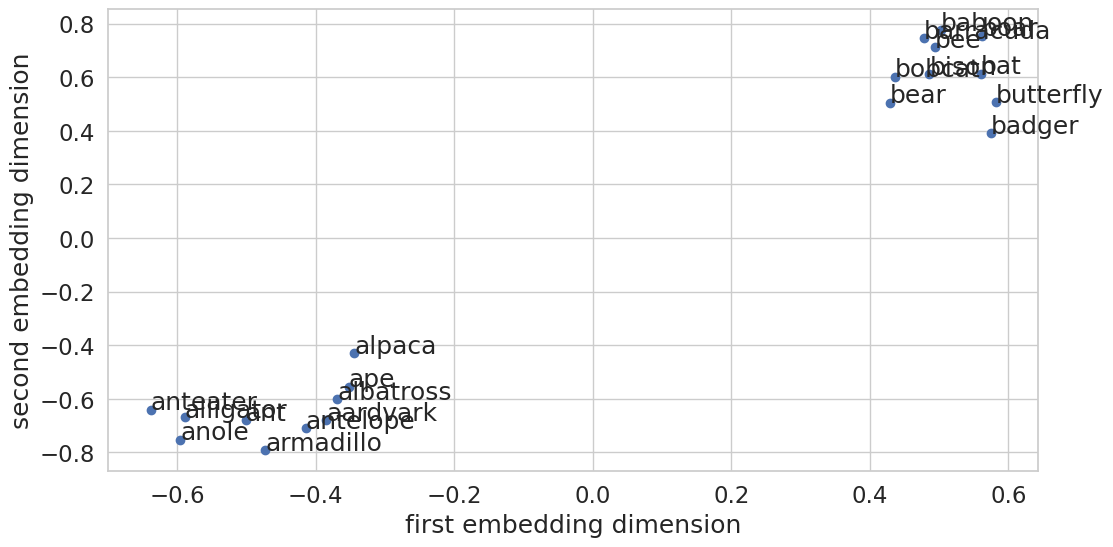

 60%|██████    | 6/10 [00:05<00:04,  1.08s/it]

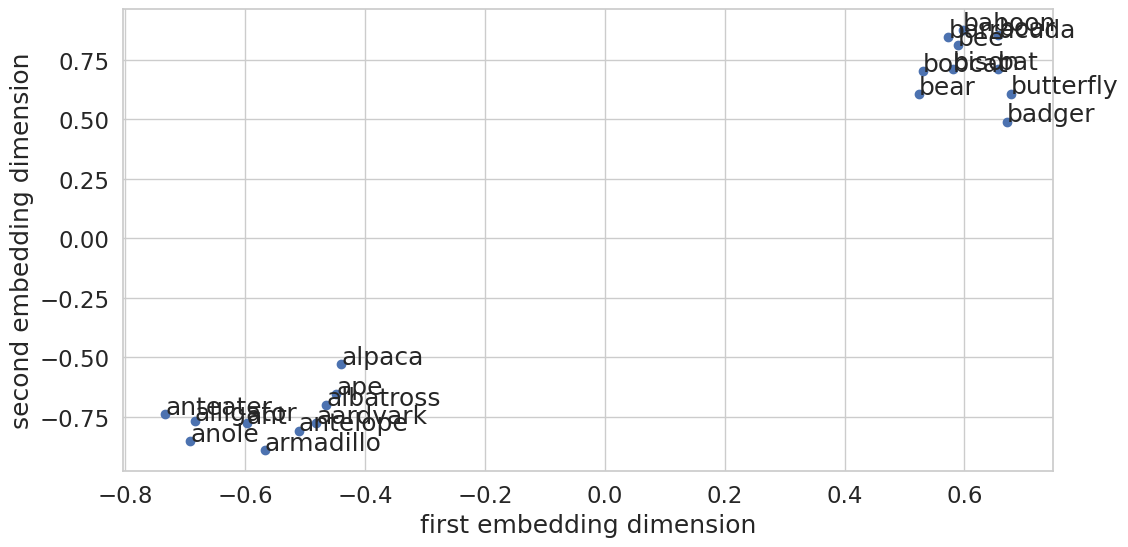

 70%|███████   | 7/10 [00:06<00:02,  1.01it/s]

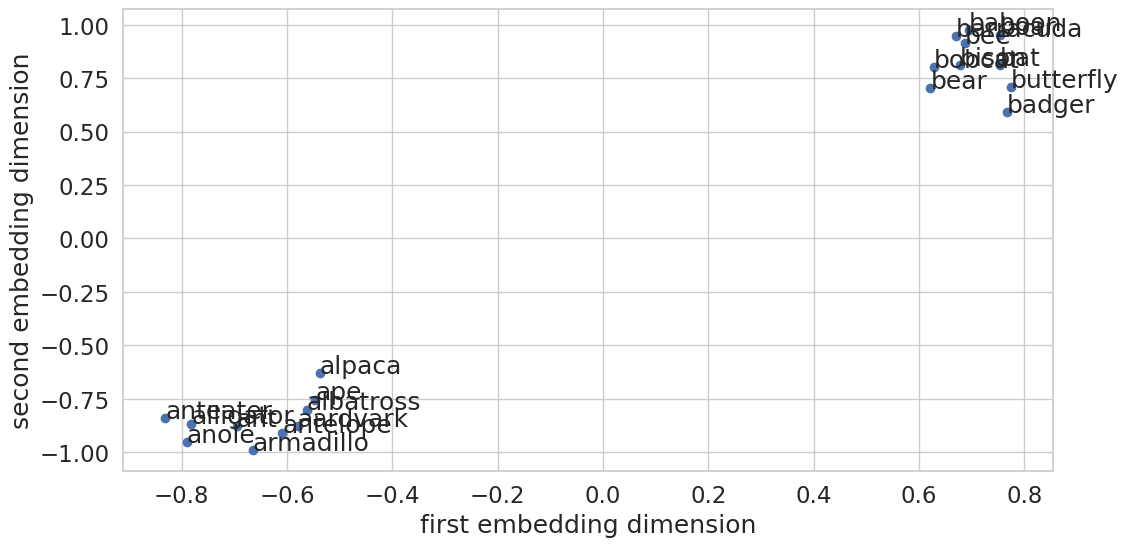

 80%|████████  | 8/10 [00:06<00:01,  1.22it/s]

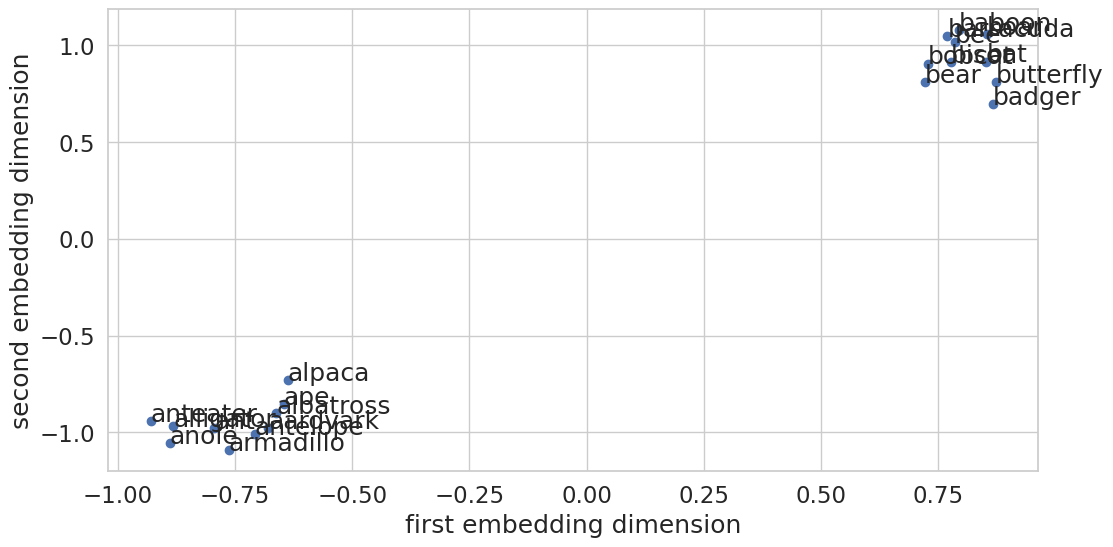

 90%|█████████ | 9/10 [00:07<00:00,  1.26it/s]

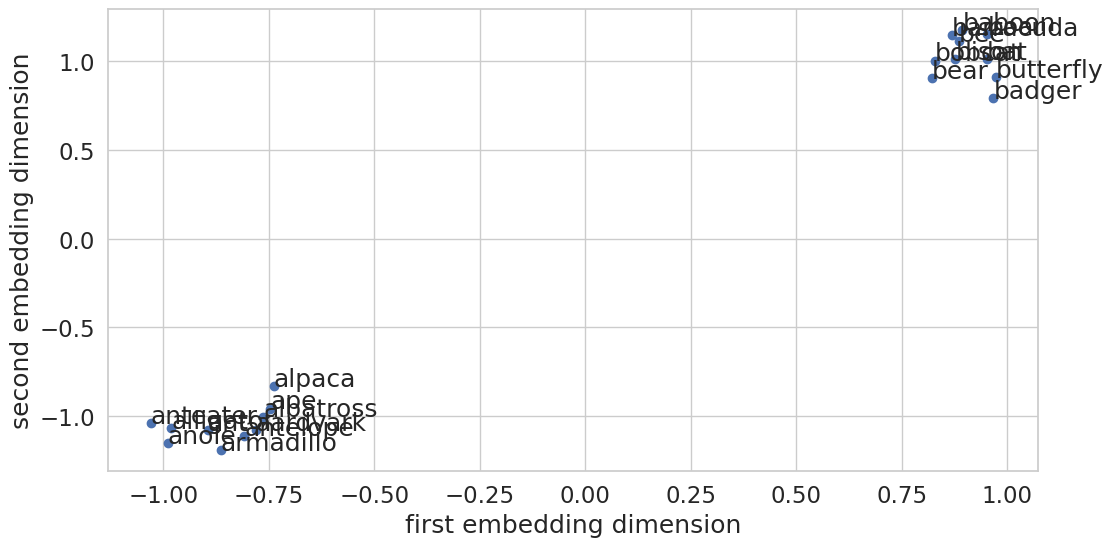

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


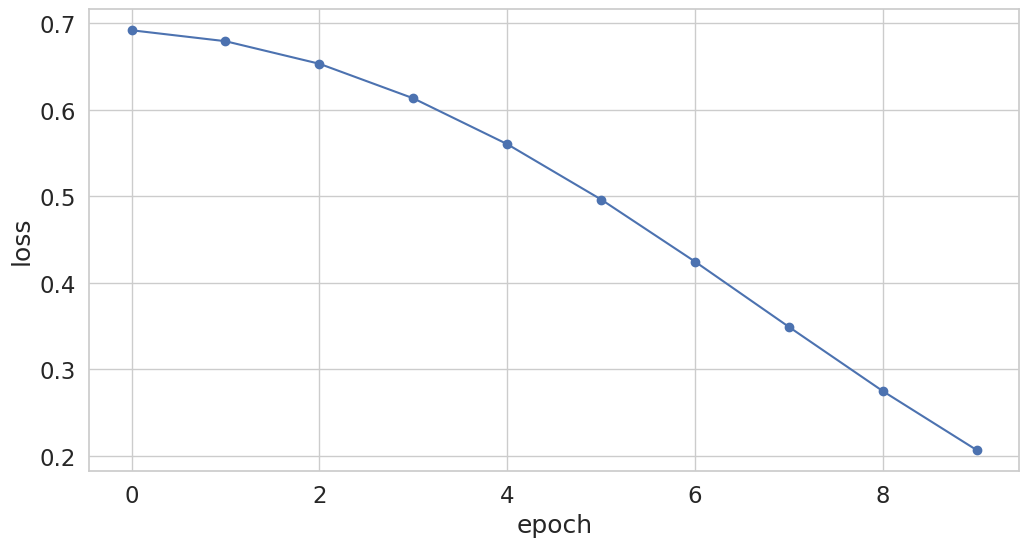

In [48]:
def train_word2vec(data, vocab):
    torch.random.manual_seed(42)
    learning_rate = 0.1
    model = Word2Vec(len(vocab), embedding_size=2)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.verbose = False

    loss_val = []
    num_epochs=10
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        optimizer.zero_grad() # reset all the gradient information
        words1, words2, labels = vectorize_batch2(data, vocab)
        outputs = model(words1, words2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_val.append(loss.item())
        animal_embeddings = [word2embedding(animal, model, vocab) for animal in animals]
        plot_embeddings(animal_embeddings, animals)

    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    return model

word2vec = train_word2vec(data2, vocab)

In [49]:
# how many parameters?
print(word2vec)

Word2Vec(
  (embedding): Linear(in_features=20, out_features=2, bias=False)
  (sigmoid): Sigmoid()
)


<br><br>

only $V * H$ parameters, since we use "parameter tying"
  - same parameters used to embed both input words.

<hr size=10 color=#285C4D>

## Pre-trained embeddings


There are many open-source word embeddings that have been pretrained on terabytes of data.

In [41]:
# download Google's pretrained word2vec vectors ~1 Gb
# also available here: https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
# this will take a while to download...
import gensim
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')

In [2]:
# key_to_index is a dict from term to index.
[v for v in w2v.key_to_index.items()][:10]

[('</s>', 0),
 ('in', 1),
 ('for', 2),
 ('that', 3),
 ('is', 4),
 ('on', 5),
 ('##', 6),
 ('The', 7),
 ('with', 8),
 ('said', 9)]

In [3]:
# how many terms?
len(w2v.key_to_index)

3000000

In [4]:
# word representation for "love"
w2v['love'][:20]

array([ 0.10302734, -0.15234375,  0.02587891,  0.16503906, -0.16503906,
        0.06689453,  0.29296875, -0.26367188, -0.140625  ,  0.20117188,
       -0.02624512, -0.08203125, -0.02770996, -0.04394531, -0.23535156,
        0.16992188,  0.12890625,  0.15722656,  0.00756836, -0.06982422],
      dtype=float32)

In [5]:
# how many dimensions?
len(w2v['love'])

300

In [7]:
# how similar are two word vectors?
w2v.distance("love", "hate")

0.3996043801307678

In [8]:
w2v.distance('love', 'school')

0.9043338373303413

In [9]:
# find similar
w2v.most_similar(positive=['ant'])

[('ants', 0.7326953411102295),
 ('insect', 0.6691938638687134),
 ('grasshoppers', 0.576737642288208),
 ('spider', 0.5640507340431213),
 ('ant_colony', 0.5585131049156189),
 ('cockroach', 0.5551186203956604),
 ('ant_nest', 0.5531710386276245),
 ('insects', 0.5530052781105042),
 ('wasp', 0.5481342077255249),
 ('beetle', 0.5468916893005371)]

### Visualizing word vectors

Since it is difficult to visualize a 300-dimensional space, we often "project down" to two dimensions using dimensionality reduction methods like PCA or UMAP.

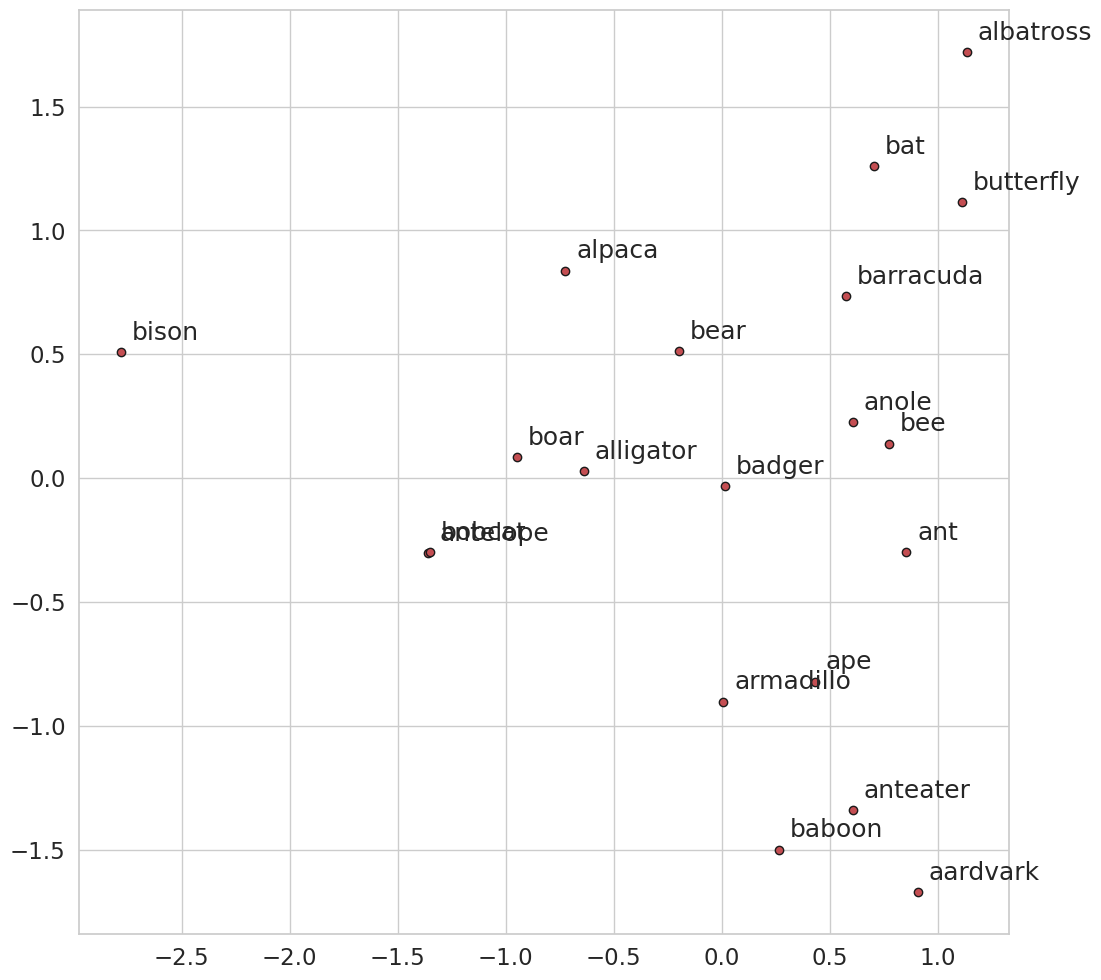

In [32]:
from sklearn.decomposition import PCA
def plot_embeddings_w2v(w2v, words):
    word_vectors = np.array([w2v[a] for a in words])
    # reduce two 2 dimensions
    twodim = PCA(random_state=42).fit_transform(word_vectors)[:,:2]
    plt.figure(figsize=(12,12))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+.05, y+.05, word)
    plt.show()

plot_embeddings_w2v(w2v, animals)

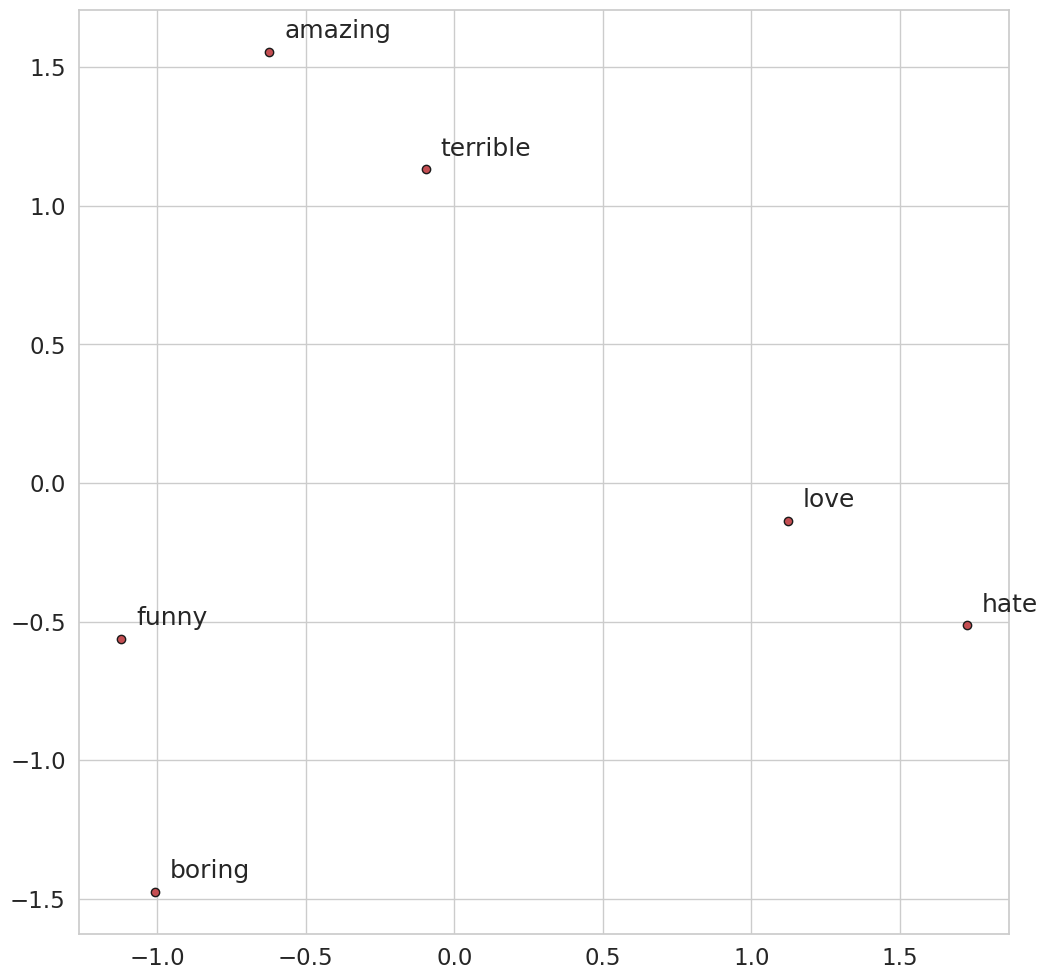

In [33]:
plot_embeddings_w2v(w2v, ['love', 'hate', 'funny', 'boring', 'amazing', 'terrible'])

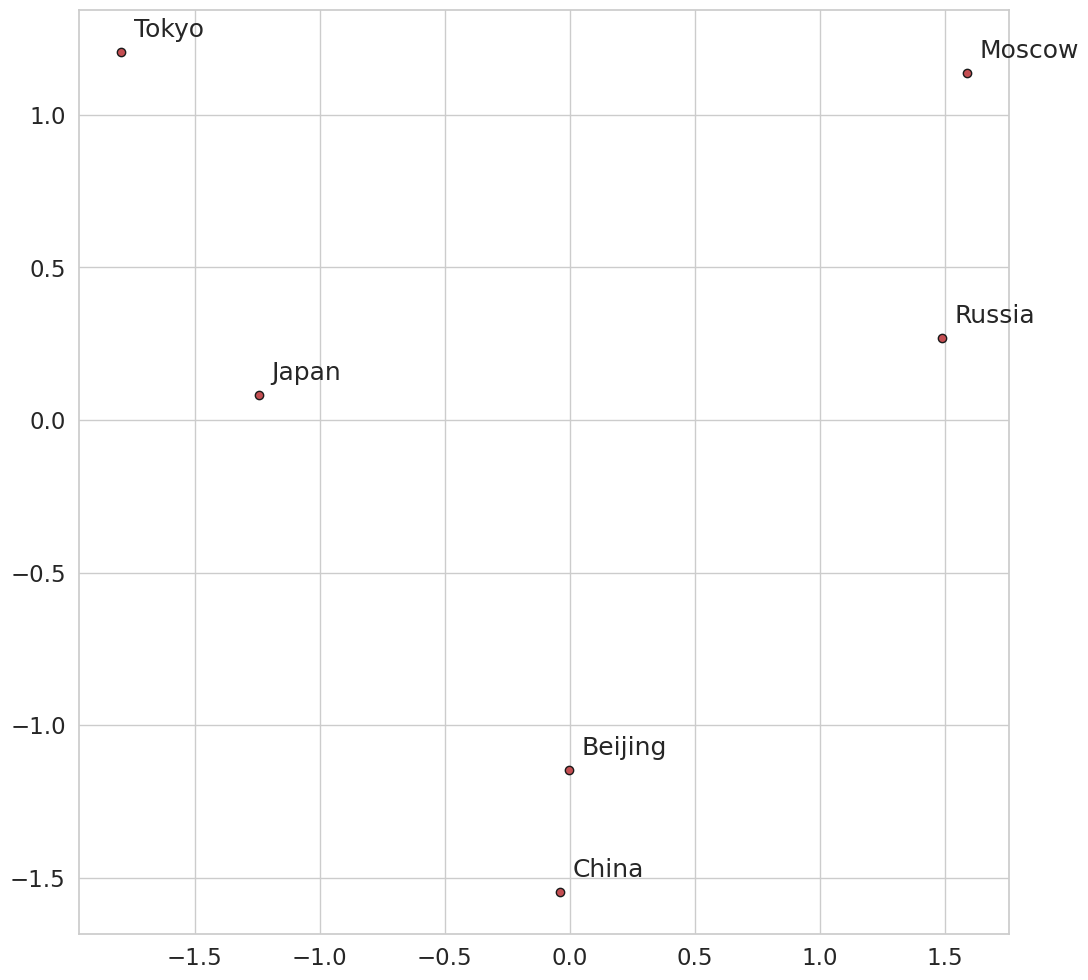

In [34]:
plot_embeddings_w2v(w2v, ['China', 'Beijing', 'Russia', 'Moscow', 'Japan', 'Tokyo'])

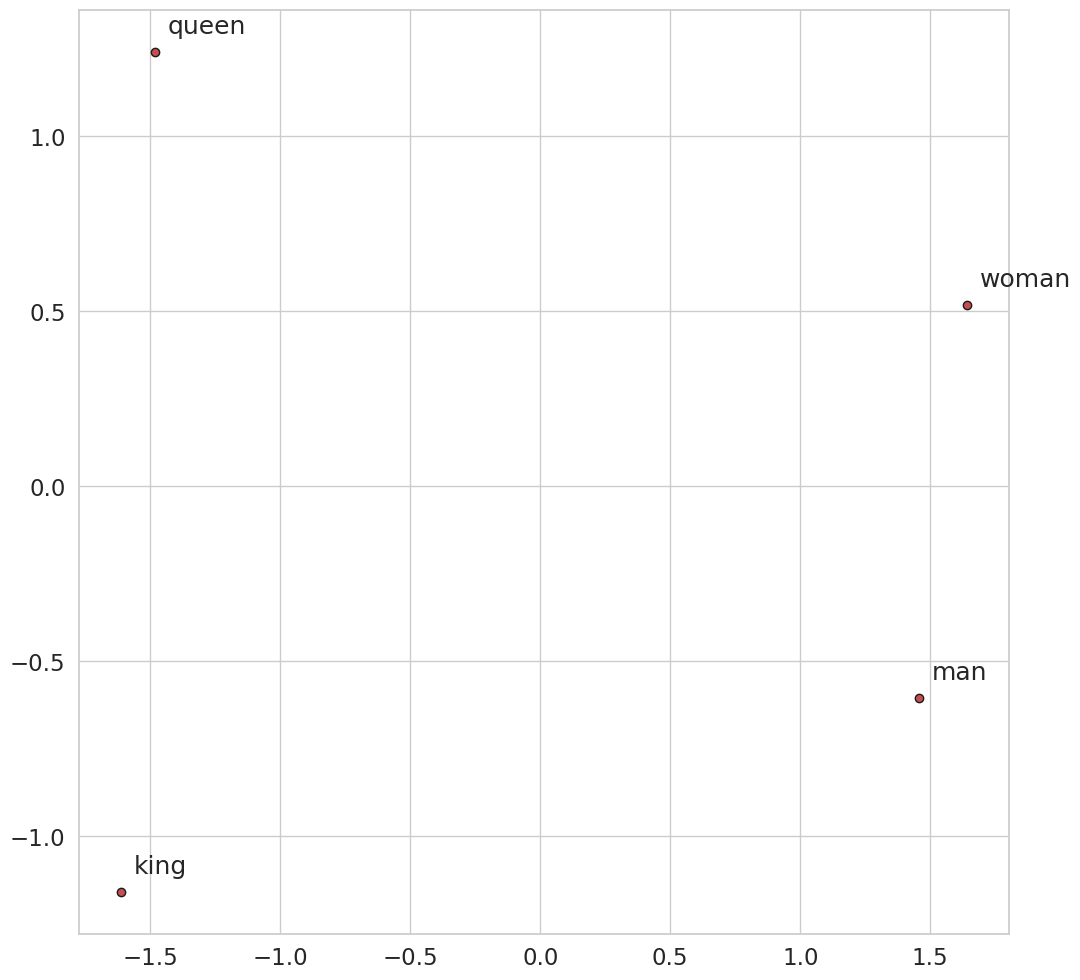

In [35]:
plot_embeddings_w2v(w2v, ['king', 'queen', 'man', 'woman'])



![vis1.jpg](https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/vis1.jpg?raw=1)

![vis2.jpg](https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/vis2.png?raw=1)

![vis3.jpg](https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/vis3.png?raw=1)



### Reasoning with embeddings

These embeddings are capturing rich information about word meaning.

Can we perform analogy tasks?

a::b c::?

woman::man  queen::king


king - man + woman =~ queen ?

In [37]:
w2v.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

In [38]:
queenlike = w2v['king'] - w2v['man'] + w2v['woman']
queenlike[:10]

array([ 0.04296875, -0.17822266, -0.12908936,  0.11523438,  0.00268555,
       -0.10229492,  0.19580078, -0.1795044 ,  0.01953125,  0.40991974],
      dtype=float32)

In [39]:
w2v.most_similar(positive=['father', 'woman'], negative=['man'])

[('mother', 0.8462507128715515),
 ('daughter', 0.7899606823921204),
 ('husband', 0.7560455799102783),
 ('son', 0.7279756665229797),
 ('eldest_daughter', 0.7120417952537537),
 ('niece', 0.7096832990646362),
 ('aunt', 0.6960803866386414),
 ('grandmother', 0.689734160900116),
 ('sister', 0.6895190477371216),
 ('daughters', 0.6731119155883789)]

In [40]:
# uh-oh...
w2v.most_similar(positive=['computer_programmer', 'woman'], negative=['man'])

[('homemaker', 0.5627118945121765),
 ('housewife', 0.5105047225952148),
 ('graphic_designer', 0.505180299282074),
 ('schoolteacher', 0.497949481010437),
 ('businesswoman', 0.493489146232605),
 ('paralegal', 0.49255111813545227),
 ('registered_nurse', 0.4907974898815155),
 ('saleswoman', 0.4881627559661865),
 ('electrical_engineer', 0.4797725975513458),
 ('mechanical_engineer', 0.4755399227142334)]

### Bias!



Models trained on data can replicate and/or amplify existing stereotypes.

<br><br><br>

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/rec.png?raw=1" width=50%/>

[source](https://spectrum.ieee.org/tech-talk/telecom/internet/women-less-likely-to-be-shown-ads-for-highpaying-jobs)
- Fairness in recommendation systems
- Experiment: create fake Google profiles, then search for jobs
- Only difference was gender
> The male profiles were much more likely to be shown ads for a career coaching service for executive positions paying over $200,000. The Google ad network showed this ad to the male users more than 1800 times, but only about 300 times to women.

### Other architectures



There have been many architectures proposed to learn useful word vectors:

$p(w_i \mid w_1 \ldots w_n)$ (before and after context)

![cbow](https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/cbow.png?raw=1)

$p(w_1 \ldots w_n \mid w_i)$ (predict context given current word)

![skip](https://github.com/tulane-cmps6730/main/blob/main/lec/language_models/figs/skip.png?raw=1)

<hr size=10 color=#285C4D>

## Group Task


- Come up with another analogy task like the king/queen example above. Describe what you tried and how you determined if it worked or not.

- Pick a word that has multiple meanings and explore its representation in Word2Vec. What word did you choose and what did you discover? What implications does this have for using these embeddings for other tasks like classification?

<hr size=10 color=#285C4D>

## Image sources



- https://engineering.aweber.com/cosine-similarity/
- http://www-personal.umich.edu/~ronxin/pdf/w2vexp.pdf
- https://deeplearning4j.org/img/countries_capitals.png
- https://adriancolyer.files.wordpress.com/2016/04/word2vec-gender-relation.png?w=600